In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import cv2
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

## Load the image Train and validation

In [2]:
train_dataset_path = '/Users/vmurugesan/Ms/Final/Proposal/Interim/DataSet/images_train_test_val/train'
validation_dataset_path = '/Users/vmurugesan/Ms/Final/Proposal/Interim/DataSet/images_train_test_val/validation'

## Load Image Datasets and Apply Augmentations

In [3]:
IMG_WIDTH = 256
IMG_HEIGHT = 256
BATCH_SIZE = 32

Loading the training dataset and applying augmentations on it.

In [4]:
train_datagen = ImageDataGenerator(rescale=1.0/255,
                                  zoom_range=0.2,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  fill_mode='nearest')
train_generator = train_datagen.flow_from_directory(train_dataset_path,
                                                   target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                   batch_size=BATCH_SIZE,
                                                   class_mode='categorical',
                                                   shuffle=True)

Found 7350 images belonging to 21 classes.


In [5]:
print(train_datagen)

In [6]:
print(train_generator)

In [7]:
validation_datagen = ImageDataGenerator(rescale=1.0/255)
validation_generator = validation_datagen.flow_from_directory(validation_dataset_path,
                                                             target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                             batch_size=BATCH_SIZE,
                                                             class_mode='categorical',
                                                             shuffle=True)

Found 2100 images belonging to 21 classes.


In [8]:
print(validation_datagen)

In [9]:
print(validation_generator)

## Get the Label Mappings

In [10]:
labels = {value: key for key, value in train_generator.class_indices.items()}

print("Label Mappings for classes present in the training and validation datasets\n")
for key, value in labels.items():
    print(f"{key} : {value}")

Label Mappings for classes present in the training and validation datasets

0 : agricultural
1 : airplane
2 : baseballdiamond
3 : beach
4 : buildings
5 : chaparral
6 : denseresidential
7 : forest
8 : freeway
9 : golfcourse
10 : harbor
11 : intersection
12 : mediumresidential
13 : mobilehomepark
14 : overpass
15 : parkinglot
16 : river
17 : runway
18 : sparseresidential
19 : storagetanks
20 : tenniscourt


## Plotting Sample Training Images

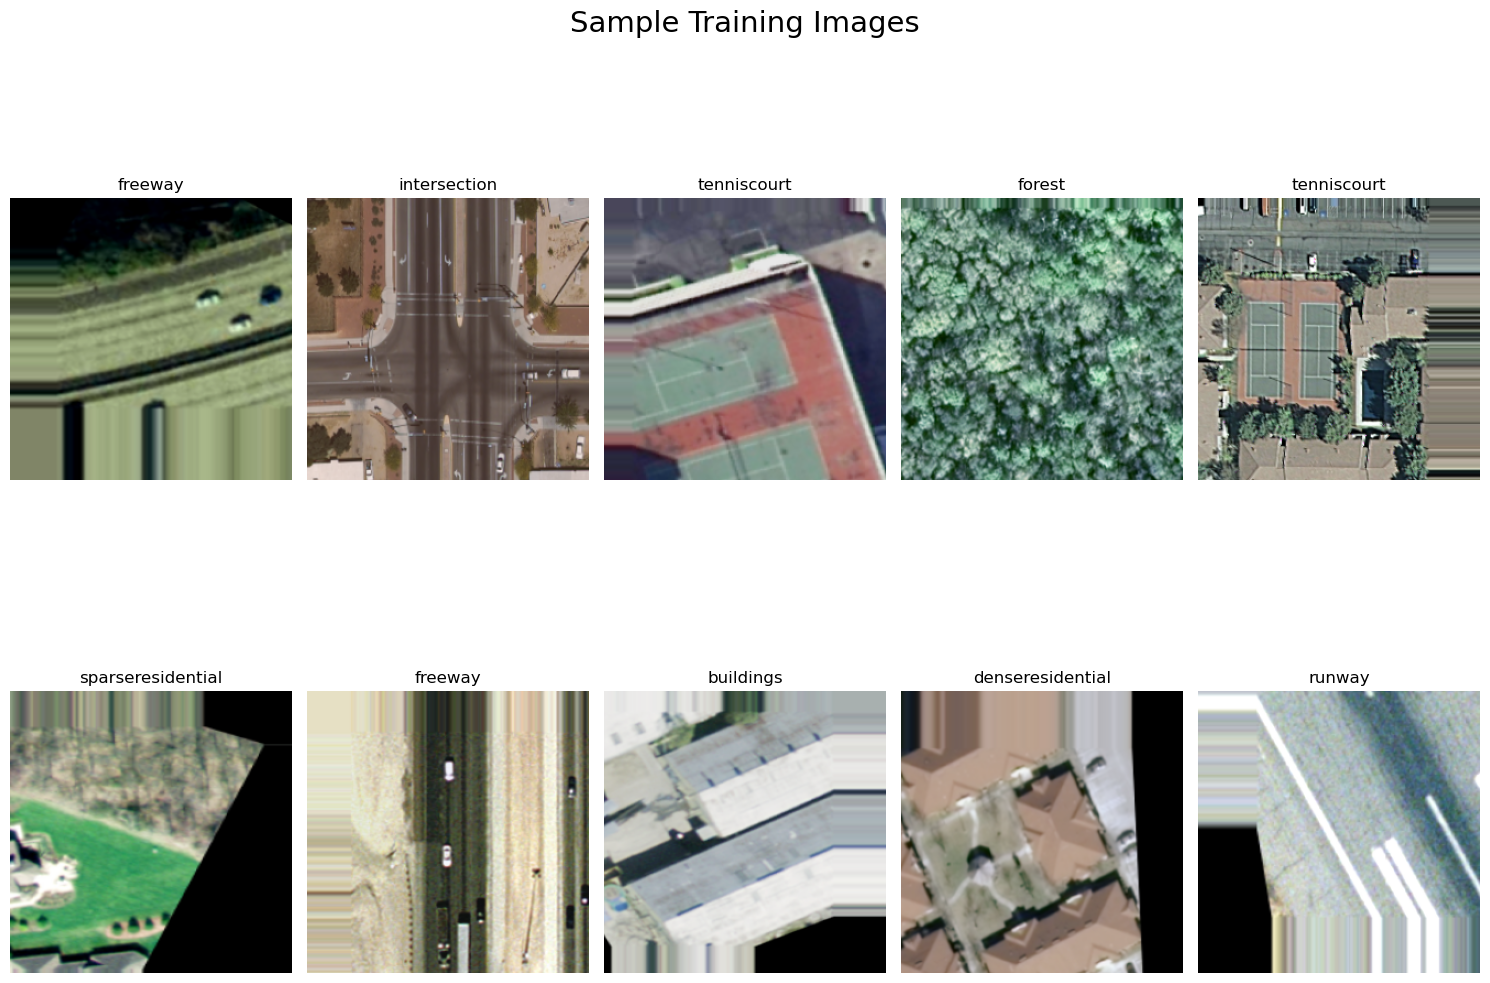

In [11]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(15, 12))
idx = 0

for i in range(2):
    for j in range(5):
        label = labels[np.argmax(train_generator[0][1][idx])]
        ax[i, j].set_title(f"{label}")
        ax[i, j].imshow(train_generator[0][0][idx][:, :, :])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Sample Training Images", fontsize=21)
plt.show()

### 4. Training a CNN Model

1. Create a CNN Model with three layers with no padding

In [12]:
def create_model():
    model = Sequential([
        Conv2D(filters=128, kernel_size=(5, 5), padding='valid', input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        
        Conv2D(filters=64, kernel_size=(3, 3), padding='valid', kernel_regularizer=l2(0.00005)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        
        Conv2D(filters=32, kernel_size=(3, 3), padding='valid', kernel_regularizer=l2(0.00005)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        
        Flatten(),
        
        Dense(units=256, activation='relu'),
        Dropout(0.5),
        Dense(units=21, activation='softmax')
    ])
    
    return model

In [13]:
cnn_model = create_model()

CNN Summary

In [14]:
print(cnn_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 252, 252, 128)     9728      
                                                                 
 activation (Activation)     (None, 252, 252, 128)     0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 126, 126, 128)     0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 126, 126, 128)     512       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 124, 124, 64)      73792     
                                                                 
 activation_1 (Activation)   (None, 124, 124, 64)      0

## Defining Callbacks
A callback is an object that can perform actions at various stages of training (e.g. at the start or end of an epoch, before or after a single batch, etc)

# Reduce Learning Rate on Plateau
Is used to reduce the learning rate when a metric has stopped improving.

In [15]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), patience=5)

Defining the Optimizer

In [16]:
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.001)

Compile the Model

In [17]:
cnn_model.compile(optimizer=optimizer, loss=CategoricalCrossentropy(), metrics=['accuracy'])


Training the Model

In [18]:
history = cnn_model.fit(train_generator, epochs=50, validation_data=validation_generator,
                       verbose=2,
                       callbacks=[reduce_lr])

Epoch 1/50
230/230 - 446s - loss: 6.7244 - accuracy: 0.1170 - val_loss: 5.0264 - val_accuracy: 0.0476 - lr: 0.0010 - 446s/epoch - 2s/step
Epoch 2/50
230/230 - 337s - loss: 3.1349 - accuracy: 0.1445 - val_loss: 2.8875 - val_accuracy: 0.0967 - lr: 0.0010 - 337s/epoch - 1s/step
Epoch 3/50
230/230 - 323s - loss: 2.7583 - accuracy: 0.1857 - val_loss: 2.7484 - val_accuracy: 0.2124 - lr: 0.0010 - 323s/epoch - 1s/step
Epoch 4/50
230/230 - 322s - loss: 2.5893 - accuracy: 0.2197 - val_loss: 5.5940 - val_accuracy: 0.1457 - lr: 0.0010 - 322s/epoch - 1s/step
Epoch 5/50
230/230 - 321s - loss: 2.4592 - accuracy: 0.2444 - val_loss: 2.7875 - val_accuracy: 0.1933 - lr: 0.0010 - 321s/epoch - 1s/step
Epoch 6/50
230/230 - 323s - loss: 2.4106 - accuracy: 0.2501 - val_loss: 2.3214 - val_accuracy: 0.2838 - lr: 0.0010 - 323s/epoch - 1s/step
Epoch 7/50
230/230 - 322s - loss: 2.2988 - accuracy: 0.2805 - val_loss: 2.9101 - val_accuracy: 0.2257 - lr: 0.0010 - 322s/epoch - 1s/step
Epoch 8/50
230/230 - 322s - loss: 

## Plotting the Model Metrics
Plotting training and validation accuracy, loss and learning rate

In [20]:
train_accuracy = history.history['accuracy']
                                 
val_accuracy = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

learning_rate = history.history['lr']

In [21]:
print(history)

In [22]:
print(train_accuracy)

[0.1170068010687828, 0.14448979496955872, 0.18571428954601288, 0.21972788870334625, 0.2443537414073944, 0.2500680387020111, 0.2805442214012146, 0.298231303691864, 0.32176870107650757, 0.3292517066001892, 0.344625860452652, 0.3541496694087982, 0.37551021575927734, 0.39972788095474243, 0.4051700532436371, 0.41646257042884827, 0.425578236579895, 0.4330612123012543, 0.4623129367828369, 0.4617687165737152, 0.4820408225059509, 0.48068028688430786, 0.49659863114356995, 0.5078911781311035, 0.5070748329162598, 0.5176870822906494, 0.5322449207305908, 0.5262585282325745, 0.5434013605117798, 0.5551020503044128, 0.5555102229118347, 0.5700680017471313, 0.5693877339363098, 0.5699319839477539, 0.5865306258201599, 0.5828571319580078, 0.6195918321609497, 0.6463945508003235, 0.6453061103820801, 0.6546939015388489, 0.6589115858078003, 0.6597278714179993, 0.6643537282943726, 0.6634013652801514, 0.6651700735092163, 0.6752380728721619, 0.6775510311126709, 0.671700656414032, 0.6850340366363525, 0.683129251003

In [23]:
print(val_accuracy)

[0.0476190485060215, 0.09666666388511658, 0.21238094568252563, 0.14571428298950195, 0.19333332777023315, 0.28380951285362244, 0.2257142812013626, 0.19285714626312256, 0.35476189851760864, 0.32904762029647827, 0.33047619462013245, 0.4590476155281067, 0.4338095188140869, 0.48380953073501587, 0.4866666793823242, 0.441904753446579, 0.4095238149166107, 0.5057142972946167, 0.5309523940086365, 0.5471428632736206, 0.5852380990982056, 0.5919047594070435, 0.48571428656578064, 0.4695238173007965, 0.6309523582458496, 0.5214285850524902, 0.5376190543174744, 0.6471428275108337, 0.6323809623718262, 0.5899999737739563, 0.6828571557998657, 0.5038095116615295, 0.6266666650772095, 0.6476190686225891, 0.6552380919456482, 0.6319047808647156, 0.7604761719703674, 0.7147619128227234, 0.7476190328598022, 0.7490476369857788, 0.761904776096344, 0.7604761719703674, 0.7614285945892334, 0.7804762125015259, 0.7942857146263123, 0.7719047665596008, 0.7671428322792053, 0.7161904573440552, 0.7719047665596008, 0.78380954

In [24]:
print(train_loss)

[6.7243547439575195, 3.1348683834075928, 2.75826096534729, 2.589291572570801, 2.4592323303222656, 2.4106452465057373, 2.2988100051879883, 2.238257646560669, 2.1671481132507324, 2.1301653385162354, 2.0788052082061768, 2.0498504638671875, 1.9424163103103638, 1.864367127418518, 1.8544385433197021, 1.8129193782806396, 1.7494237422943115, 1.7244511842727661, 1.677914023399353, 1.6590486764907837, 1.61565101146698, 1.5744794607162476, 1.559334635734558, 1.5235306024551392, 1.5288139581680298, 1.4753001928329468, 1.4409805536270142, 1.4513567686080933, 1.4029655456542969, 1.3870095014572144, 1.344174861907959, 1.3185853958129883, 1.3200595378875732, 1.3171477317810059, 1.2879163026809692, 1.2703580856323242, 1.1449549198150635, 1.074379563331604, 1.065602421760559, 1.0521605014801025, 1.0335739850997925, 1.023472547531128, 1.0086628198623657, 1.014378309249878, 0.9886738061904907, 0.9689404368400574, 0.9601948857307434, 0.9755396246910095, 0.9766286611557007, 0.9383633732795715]


In [25]:
print(val_loss)

[5.0264105796813965, 2.8875129222869873, 2.748417854309082, 5.593984603881836, 2.787501096725464, 2.321357250213623, 2.9101359844207764, 3.0040268898010254, 2.124633550643921, 2.1400647163391113, 2.717980146408081, 1.7513867616653442, 1.8749104738235474, 1.5993698835372925, 1.6870739459991455, 1.790397047996521, 1.8791887760162354, 1.640354037284851, 1.4123499393463135, 1.5266410112380981, 1.3287832736968994, 1.3910303115844727, 1.696916937828064, 2.1786913871765137, 1.1667709350585938, 1.4985591173171997, 1.6361044645309448, 1.1454801559448242, 1.2560734748840332, 1.424986720085144, 1.0369539260864258, 1.9966036081314087, 1.257877230644226, 1.1671842336654663, 1.1606009006500244, 1.3123700618743896, 0.7786657810211182, 0.8961424827575684, 0.7905590534210205, 0.7995191216468811, 0.7566182017326355, 0.7410809993743896, 0.7541178464889526, 0.7183526158332825, 0.6928149461746216, 0.7198453545570374, 0.7683470249176025, 0.9152576923370361, 0.7381353378295898, 0.7610234022140503]


In [26]:
print(learning_rate)

[0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.0003162278, 0.0003162278, 0.0003162278, 0.0003162278, 0.0003162278, 0.0003162278, 0.0003162278, 0.0003162278, 0.0003162278, 0.0003162278, 0.0003162278, 0.0003162278, 0.0003162278, 0.0003162278]


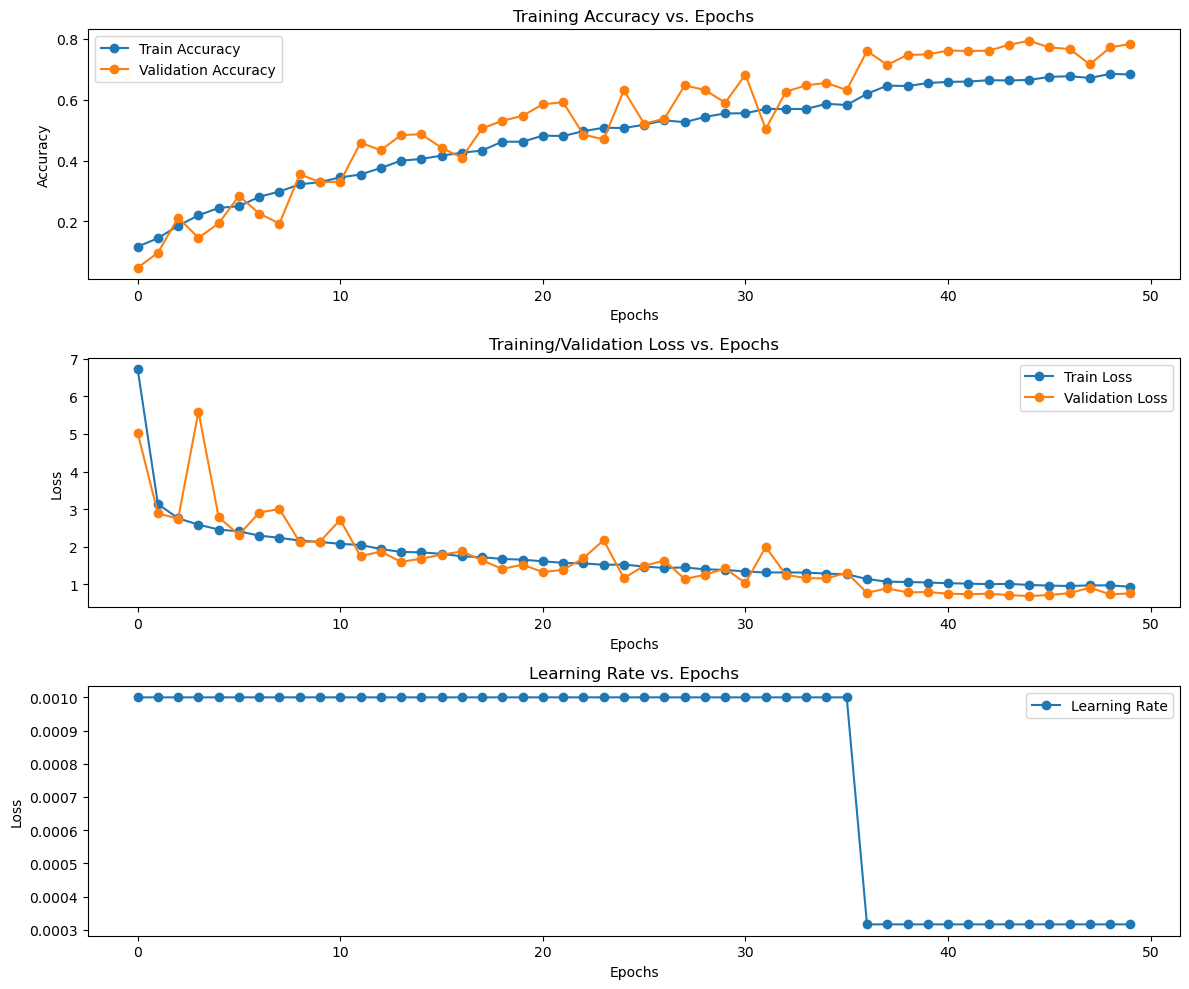

In [27]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(12, 10))

ax[0].set_title('Training Accuracy vs. Epochs')
ax[0].plot(train_accuracy, 'o-', label='Train Accuracy')
ax[0].plot(val_accuracy, 'o-', label='Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='best')

ax[1].set_title('Training/Validation Loss vs. Epochs')
ax[1].plot(train_loss, 'o-', label='Train Loss')
ax[1].plot(val_loss, 'o-', label='Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='best')

ax[2].set_title('Learning Rate vs. Epochs')
ax[2].plot(learning_rate, 'o-', label='Learning Rate')
ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('Loss')
ax[2].legend(loc='best')

plt.tight_layout()
plt.show()

Testing the Model on Test Set

In [28]:
test_dataset = '/Users/vmurugesan/Ms/Final/Proposal/Interim/DataSet/images_train_test_val/test'


In [29]:
test_datagen = ImageDataGenerator(rescale=1.0/255)

test_generator = test_datagen.flow_from_directory(test_dataset,
                                                 shuffle=False,
                                                 batch_size=BATCH_SIZE,
                                                 target_size = (IMG_WIDTH, IMG_HEIGHT),
                                                 class_mode='categorical')


Found 1050 images belonging to 21 classes.


In [30]:
print(test_datagen)

In [31]:
print(test_generator)

Model Prediction on the Test Dataset

In [32]:
predictions = cnn_model.predict(test_generator)

33/33 [==============================] - 11s 343ms/step


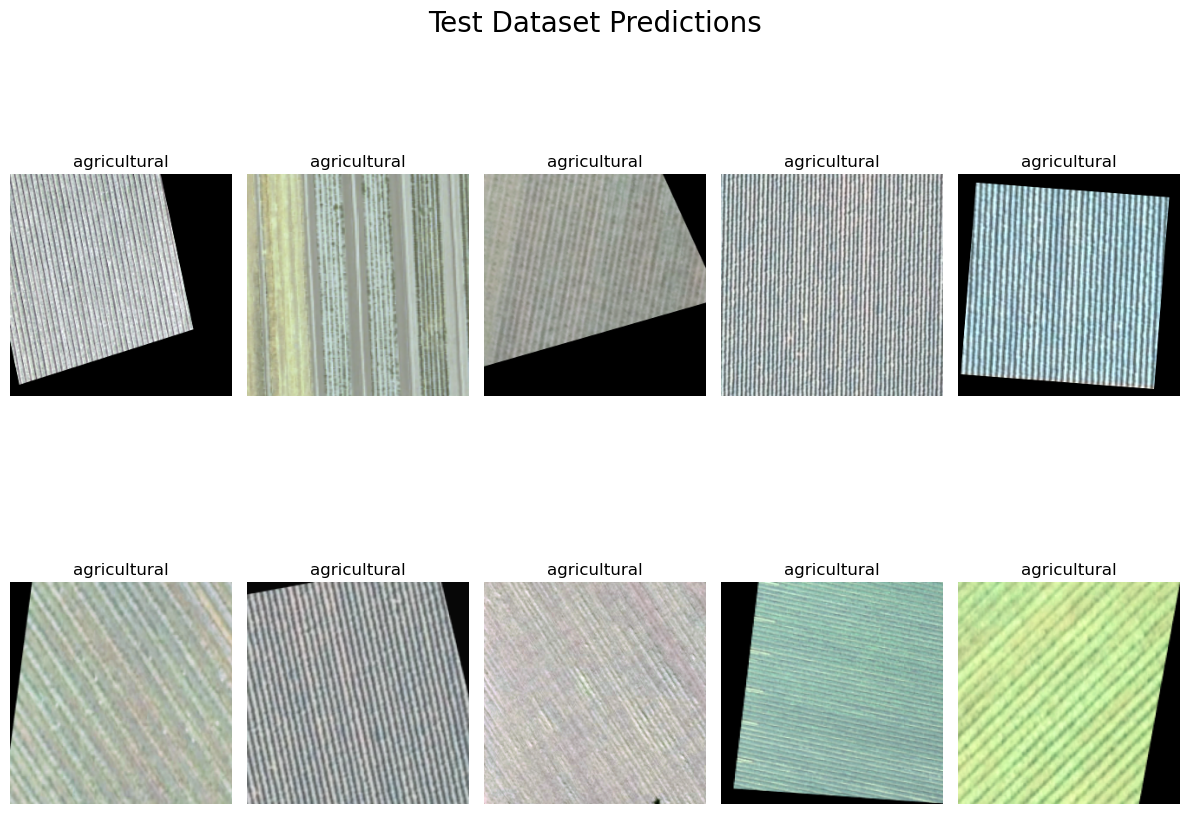

In [33]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(12, 10))
idx = 0

for i in range(2):
    for j in range(5):
        predicted_label = labels[np.argmax(predictions[idx])]
        ax[i, j].set_title(f"{predicted_label}")
        ax[i, j].imshow(test_generator[0][0][idx])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Test Dataset Predictions", fontsize=20)
plt.show()

In [34]:
test_loss, test_accuracy = cnn_model.evaluate(test_generator, batch_size=BATCH_SIZE)

33/33 [==============================] - 11s 341ms/step - loss: 0.7586 - accuracy: 0.7771


In [35]:
print(f"Test Loss:     {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Test Loss:     0.7586423754692078
Test Accuracy: 0.7771428823471069


The test loss and test accuracy is the same as validation loss and validation accuracy at the last step since the testing and validation datasets are same.

In [36]:
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

In [37]:
print(y_pred)

[ 0  0  0 ... 11 20 20]


In [38]:
print(y_true)

[ 0  0  0 ... 20 20 20]


## Confusion Matrix

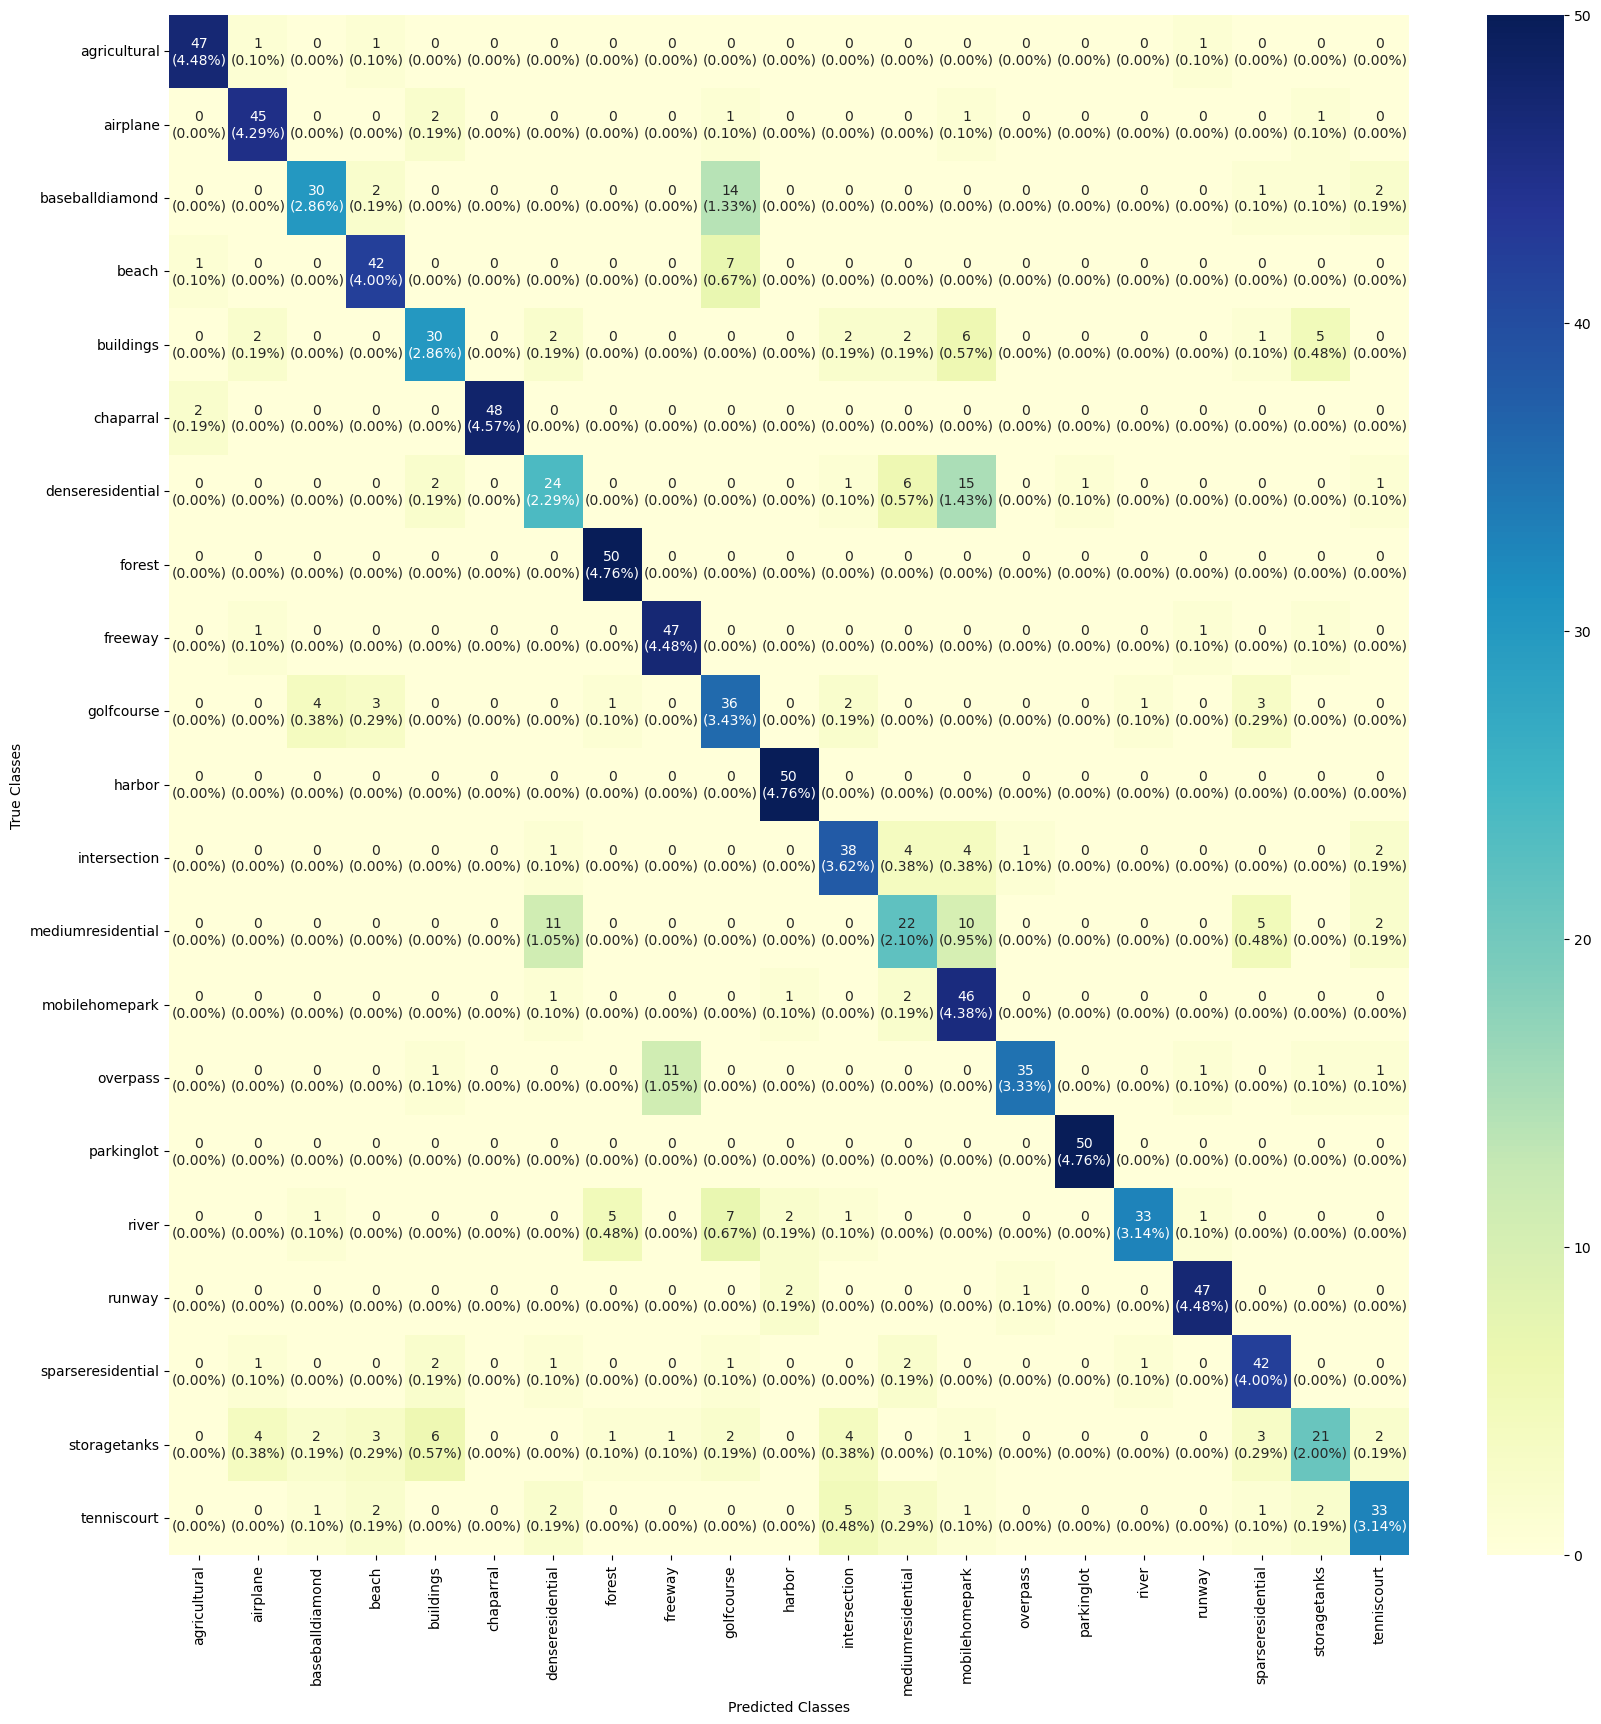

In [39]:
cf_mtx = confusion_matrix(y_true, y_pred)

group_counts = ["{0:0.0f}".format(value) for value in cf_mtx.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_mtx.flatten() / np.sum(cf_mtx)]
box_labels = [f"{v1}\n({v2})" for v1, v2 in zip(group_counts, group_percentages)]
box_labels = np.asarray(box_labels).reshape(cf_mtx.shape)  # Modify this line to use cf_mtx.shape instead of hardcoding (441, 441)

plt.figure(figsize=(20, 20))
sns.heatmap(cf_mtx, xticklabels=labels.values(), yticklabels=labels.values(),
            cmap="YlGnBu", fmt="", annot=box_labels)
plt.xlabel('Predicted Classes')
plt.ylabel('True Classes')
plt.show()

## Classification Report

In [40]:
df_data=classification_report(y_true, y_pred, target_names=labels.values())

In [41]:
type(df_data)


str

In [42]:
from sklearn.metrics import accuracy_score
accuracy_score(y_true, y_pred)

0.7771428571428571

In [43]:
from sklearn.metrics import precision_score
precision_score(y_true, y_pred, average=None)

array([0.94      , 0.83333333, 0.78947368, 0.79245283, 0.69767442,
       1.        , 0.57142857, 0.87719298, 0.79661017, 0.52941176,
       0.90909091, 0.71698113, 0.53658537, 0.54761905, 0.94594595,
       0.98039216, 0.94285714, 0.92156863, 0.75      , 0.65625   ,
       0.76744186])

In [44]:
from sklearn.metrics import recall_score
recall_score(y_true, y_pred, average=None)

array([0.94, 0.9 , 0.6 , 0.84, 0.6 , 0.96, 0.48, 1.  , 0.94, 0.72, 1.  ,
       0.76, 0.44, 0.92, 0.7 , 1.  , 0.66, 0.94, 0.84, 0.42, 0.66])

In [45]:
from sklearn.metrics import f1_score
f1_score(y_true, y_pred, average=None)

array([0.94      , 0.86538462, 0.68181818, 0.81553398, 0.64516129,
       0.97959184, 0.52173913, 0.93457944, 0.86238532, 0.61016949,
       0.95238095, 0.73786408, 0.48351648, 0.68656716, 0.8045977 ,
       0.99009901, 0.77647059, 0.93069307, 0.79245283, 0.51219512,
       0.70967742])

In [46]:
matrix = confusion_matrix(y_true, y_pred)
matrix.diagonal()/matrix.sum(axis=1)

array([0.94, 0.9 , 0.6 , 0.84, 0.6 , 0.96, 0.48, 1.  , 0.94, 0.72, 1.  ,
       0.76, 0.44, 0.92, 0.7 , 1.  , 0.66, 0.94, 0.84, 0.42, 0.66])

In [47]:
cf_mtx = confusion_matrix(y_true, y_pred)

In [48]:
print(classification_report(y_true, y_pred, target_names=labels.values()))


                   precision    recall  f1-score   support

     agricultural       0.94      0.94      0.94        50
         airplane       0.83      0.90      0.87        50
  baseballdiamond       0.79      0.60      0.68        50
            beach       0.79      0.84      0.82        50
        buildings       0.70      0.60      0.65        50
        chaparral       1.00      0.96      0.98        50
 denseresidential       0.57      0.48      0.52        50
           forest       0.88      1.00      0.93        50
          freeway       0.80      0.94      0.86        50
       golfcourse       0.53      0.72      0.61        50
           harbor       0.91      1.00      0.95        50
     intersection       0.72      0.76      0.74        50
mediumresidential       0.54      0.44      0.48        50
   mobilehomepark       0.55      0.92      0.69        50
         overpass       0.95      0.70      0.80        50
       parkinglot       0.98      1.00      0.99       

In [49]:
print(type(cf_mtx))

<class 'numpy.ndarray'>


In [50]:
errors = (y_true - y_pred != 0)
y_true_errors = y_true[errors]
y_pred_errors = y_pred[errors]

In [51]:
print(errors)

[False False False ...  True False False]


In [52]:
test_images = test_generator.filenames
test_img = np.asarray(test_images)[errors]

In [53]:
print(test_images)

['agricultural/agricultural_000007.png', 'agricultural/agricultural_000028.png', 'agricultural/agricultural_000033.png', 'agricultural/agricultural_000042.png', 'agricultural/agricultural_000052.png', 'agricultural/agricultural_000055.png', 'agricultural/agricultural_000058.png', 'agricultural/agricultural_000063.png', 'agricultural/agricultural_000085.png', 'agricultural/agricultural_000087.png', 'agricultural/agricultural_000093.png', 'agricultural/agricultural_000096.png', 'agricultural/agricultural_000102.png', 'agricultural/agricultural_000111.png', 'agricultural/agricultural_000118.png', 'agricultural/agricultural_000137.png', 'agricultural/agricultural_000158.png', 'agricultural/agricultural_000172.png', 'agricultural/agricultural_000189.png', 'agricultural/agricultural_000203.png', 'agricultural/agricultural_000231.png', 'agricultural/agricultural_000235.png', 'agricultural/agricultural_000237.png', 'agricultural/agricultural_000248.png', 'agricultural/agricultural_000250.png',

In [54]:
print(test_img)

['agricultural/agricultural_000111.png'
 'agricultural/agricultural_000351.png'
 'agricultural/agricultural_000467.png' 'airplane/airplane_000274.png'
 'airplane/airplane_000304.png' 'airplane/airplane_000350.png'
 'airplane/airplane_000406.png' 'airplane/airplane_000412.png'
 'baseballdiamond/baseballdiamond_000006.png'
 'baseballdiamond/baseballdiamond_000007.png'
 'baseballdiamond/baseballdiamond_000018.png'
 'baseballdiamond/baseballdiamond_000033.png'
 'baseballdiamond/baseballdiamond_000054.png'
 'baseballdiamond/baseballdiamond_000068.png'
 'baseballdiamond/baseballdiamond_000069.png'
 'baseballdiamond/baseballdiamond_000073.png'
 'baseballdiamond/baseballdiamond_000112.png'
 'baseballdiamond/baseballdiamond_000177.png'
 'baseballdiamond/baseballdiamond_000229.png'
 'baseballdiamond/baseballdiamond_000267.png'
 'baseballdiamond/baseballdiamond_000312.png'
 'baseballdiamond/baseballdiamond_000325.png'
 'baseballdiamond/baseballdiamond_000403.png'
 'baseballdiamond/baseballdiamond

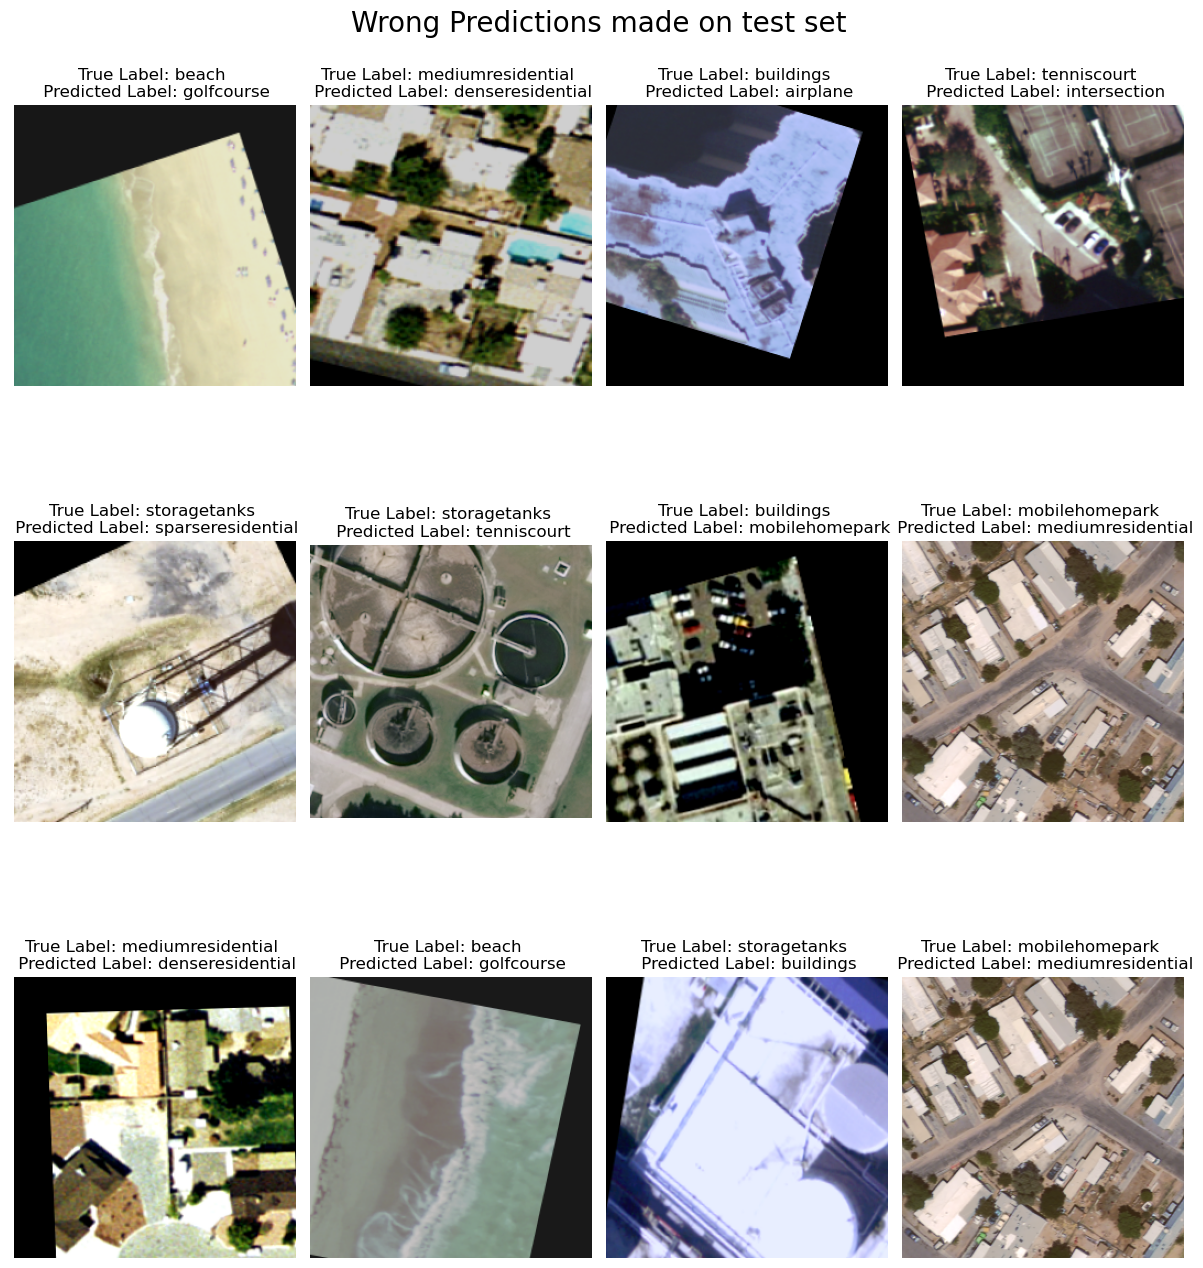

In [55]:
fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(12, 14))
idx = 0

for i in range(3):
    for j in range(4):
        idx = np.random.randint(0, len(test_img))
        true_index = y_true_errors[idx]
        true_label = labels[true_index]
        predicted_index = y_pred_errors[idx]
        predicted_label = labels[predicted_index]
        ax[i, j].set_title(f"True Label: {true_label} \n Predicted Label: {predicted_label}")
        img_path = os.path.join(test_dataset, test_img[idx])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax[i, j].imshow(img)
        ax[i, j].axis("off")

plt.tight_layout()
plt.suptitle('Wrong Predictions made on test set', fontsize=20)
plt.show()

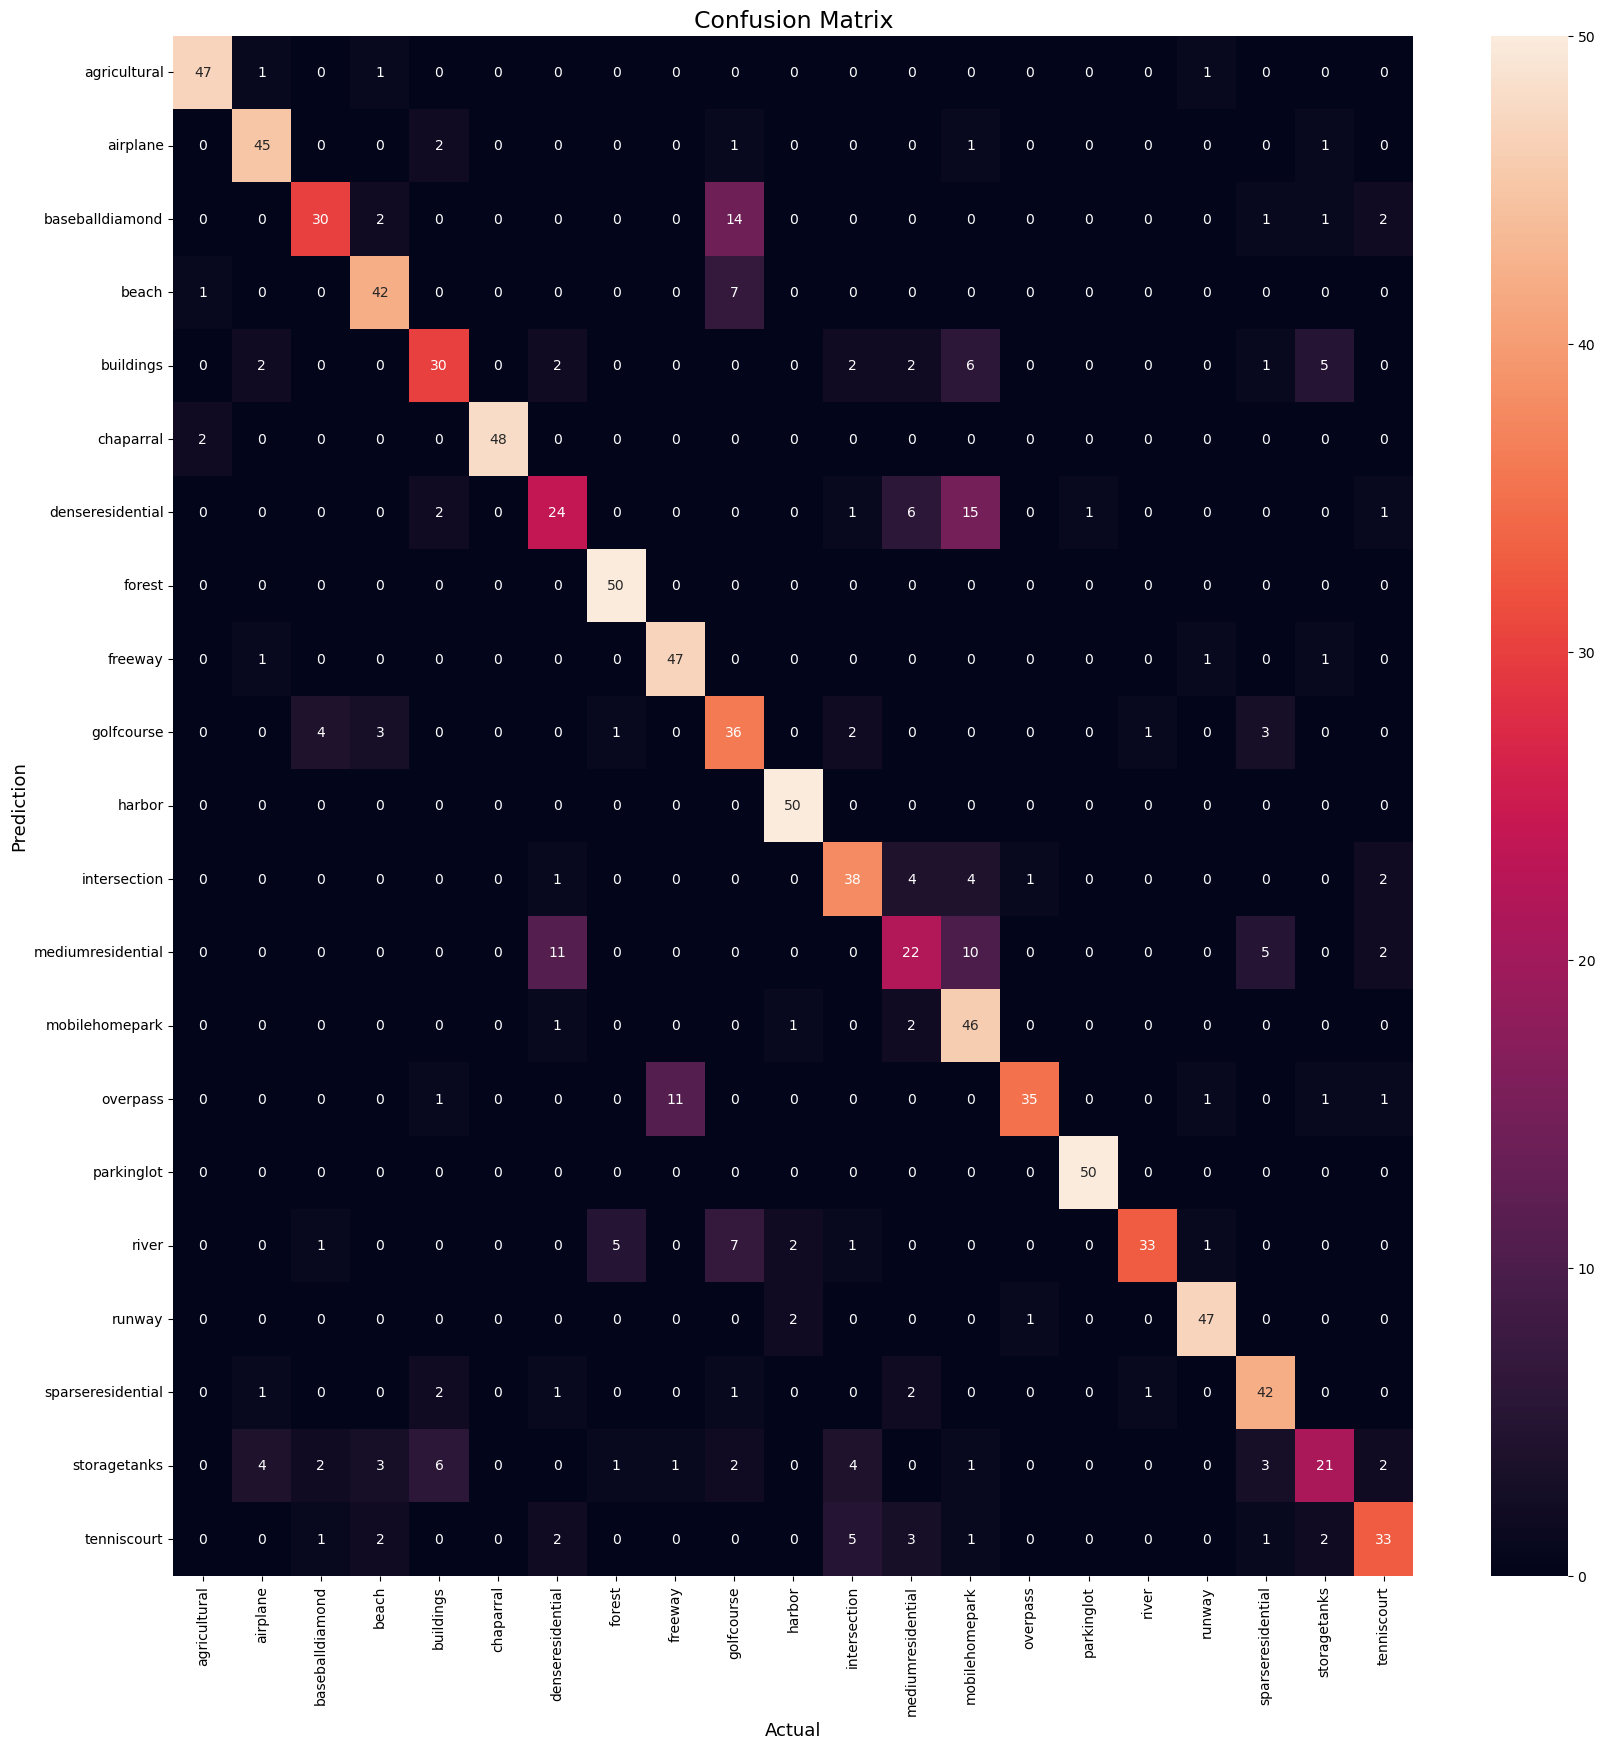

In [56]:
conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(20, 20))

sns.heatmap(conf_matrix,annot=True,xticklabels=["agricultural","airplane","baseballdiamond","beach","buildings","chaparral","denseresidential","forest","freeway","golfcourse","harbor","intersection","mediumresidential","mobilehomepark","overpass","parkinglot","river","runway","sparseresidential","storagetanks","tenniscourt"],
            yticklabels=["agricultural","airplane","baseballdiamond","beach","buildings","chaparral","denseresidential","forest","freeway","golfcourse","harbor","intersection","mediumresidential","mobilehomepark","overpass","parkinglot","river","runway","sparseresidential","storagetanks","tenniscourt"])

plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()

### More layer 

In [57]:
def create_model1():
    model = Sequential([
        Conv2D(filters=128, kernel_size=(5, 5), padding='valid', input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        
        Conv2D(filters=64, kernel_size=(3, 3), padding='valid', kernel_regularizer=l2(0.00005)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        
        Conv2D(filters=32, kernel_size=(3, 3), padding='valid', kernel_regularizer=l2(0.00005)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        
        Conv2D(filters=22, kernel_size=(2, 2), padding='valid', kernel_regularizer=l2(0.00005)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        
        Flatten(),
        
        Dense(units=256, activation='relu'),
        Dropout(0.5),
        Dense(units=21, activation='softmax')
    ])
    
    return model

In [58]:
cnn_model1 = create_model1()

In [59]:
print(cnn_model1.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 252, 252, 128)     9728      
                                                                 
 activation_3 (Activation)   (None, 252, 252, 128)     0         
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 126, 126, 128)     0         
 g2D)                                                            
                                                                 
 batch_normalization_3 (Bat  (None, 126, 126, 128)     512       
 chNormalization)                                                
                                                                 
 conv2d_4 (Conv2D)           (None, 124, 124, 64)      73792     
                                                                 
 activation_4 (Activation)   (None, 124, 124, 64)     

In [60]:
cnn_model1.compile(optimizer=optimizer, loss=CategoricalCrossentropy(), metrics=['accuracy'])

In [61]:
history1 = cnn_model1.fit(train_generator, epochs=50, validation_data=validation_generator,
                       verbose=2,
                       callbacks=[reduce_lr])

Epoch 1/50
230/230 - 345s - loss: 3.1533 - accuracy: 0.2181 - val_loss: 3.8291 - val_accuracy: 0.0857 - lr: 1.0000e-04 - 345s/epoch - 1s/step
Epoch 2/50
230/230 - 345s - loss: 2.3728 - accuracy: 0.3223 - val_loss: 2.5567 - val_accuracy: 0.2395 - lr: 1.0000e-04 - 345s/epoch - 1s/step
Epoch 3/50
230/230 - 349s - loss: 2.1175 - accuracy: 0.3754 - val_loss: 1.7930 - val_accuracy: 0.4576 - lr: 1.0000e-04 - 349s/epoch - 2s/step
Epoch 4/50
230/230 - 336s - loss: 1.9924 - accuracy: 0.4078 - val_loss: 1.6404 - val_accuracy: 0.4886 - lr: 1.0000e-04 - 336s/epoch - 1s/step
Epoch 5/50
230/230 - 336s - loss: 1.8760 - accuracy: 0.4298 - val_loss: 1.5908 - val_accuracy: 0.4914 - lr: 1.0000e-04 - 336s/epoch - 1s/step
Epoch 6/50
230/230 - 341s - loss: 1.7847 - accuracy: 0.4558 - val_loss: 1.4872 - val_accuracy: 0.5467 - lr: 1.0000e-04 - 341s/epoch - 1s/step
Epoch 7/50
230/230 - 345s - loss: 1.7186 - accuracy: 0.4732 - val_loss: 1.8656 - val_accuracy: 0.4324 - lr: 1.0000e-04 - 345s/epoch - 2s/step
Epoch 

In [62]:
train_accuracy1 = history1.history['accuracy']
                                 
val_accuracy1 = history1.history['val_accuracy']

train_loss1 = history1.history['loss']
val_loss1 = history1.history['val_loss']

learning_rate1 = history1.history['lr']

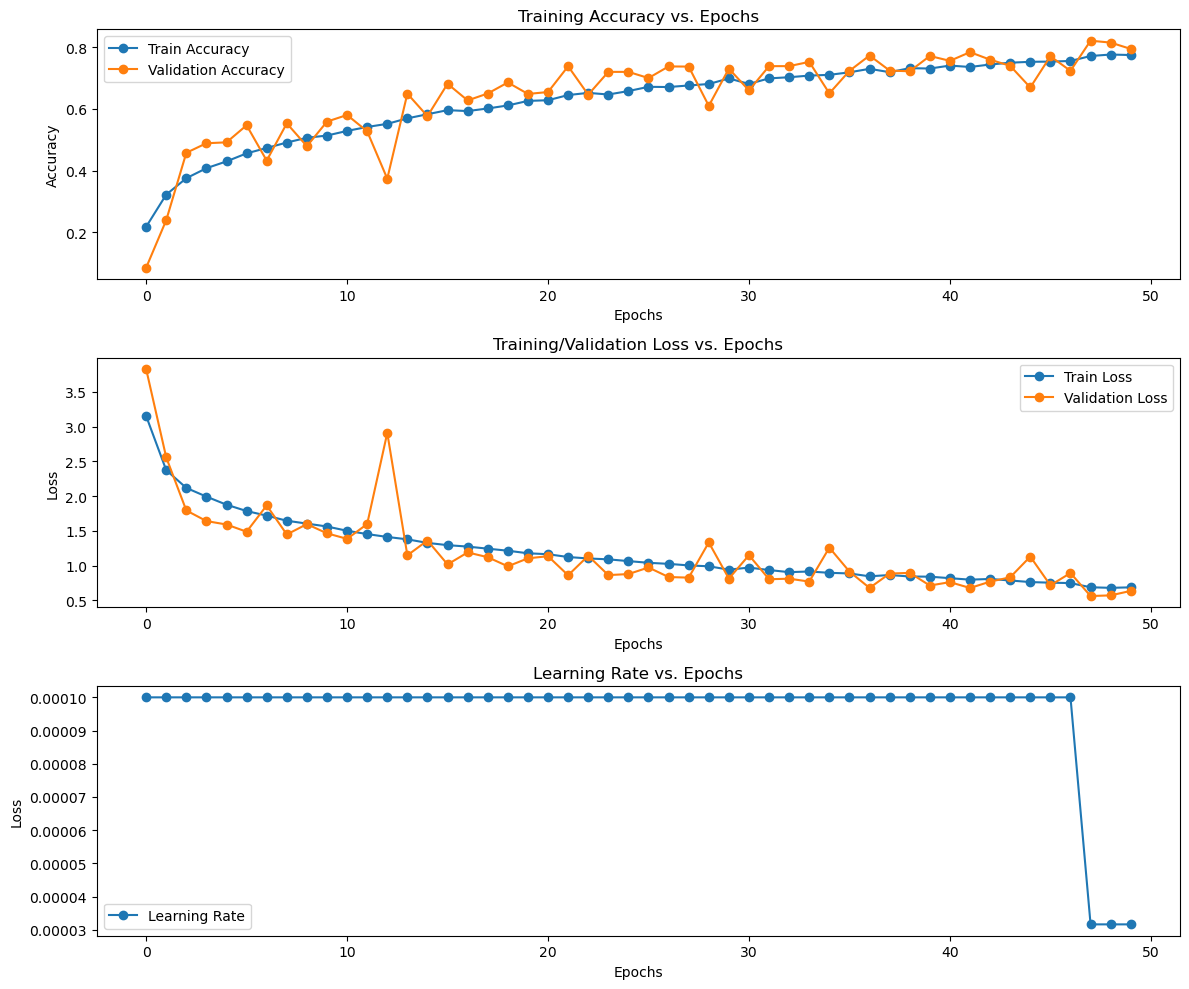

In [63]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(12, 10))

ax[0].set_title('Training Accuracy vs. Epochs')
ax[0].plot(train_accuracy1, 'o-', label='Train Accuracy')
ax[0].plot(val_accuracy1, 'o-', label='Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='best')

ax[1].set_title('Training/Validation Loss vs. Epochs')
ax[1].plot(train_loss1, 'o-', label='Train Loss')
ax[1].plot(val_loss1, 'o-', label='Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='best')

ax[2].set_title('Learning Rate vs. Epochs')
ax[2].plot(learning_rate1, 'o-', label='Learning Rate')
ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('Loss')
ax[2].legend(loc='best')

plt.tight_layout()
plt.show()

In [64]:
test_loss1, test_accuracy1 = cnn_model1.evaluate(test_generator, batch_size=BATCH_SIZE)

33/33 [==============================] - 11s 338ms/step - loss: 0.6686 - accuracy: 0.7924


In [65]:
print(f"Test Loss:     {test_loss1}")
print(f"Test Accuracy: {test_accuracy1}")

Test Loss:     0.6685805320739746
Test Accuracy: 0.7923809289932251


In [66]:
y_pred1 = np.argmax(predictions, axis=1)
y_true1 = test_generator.classes

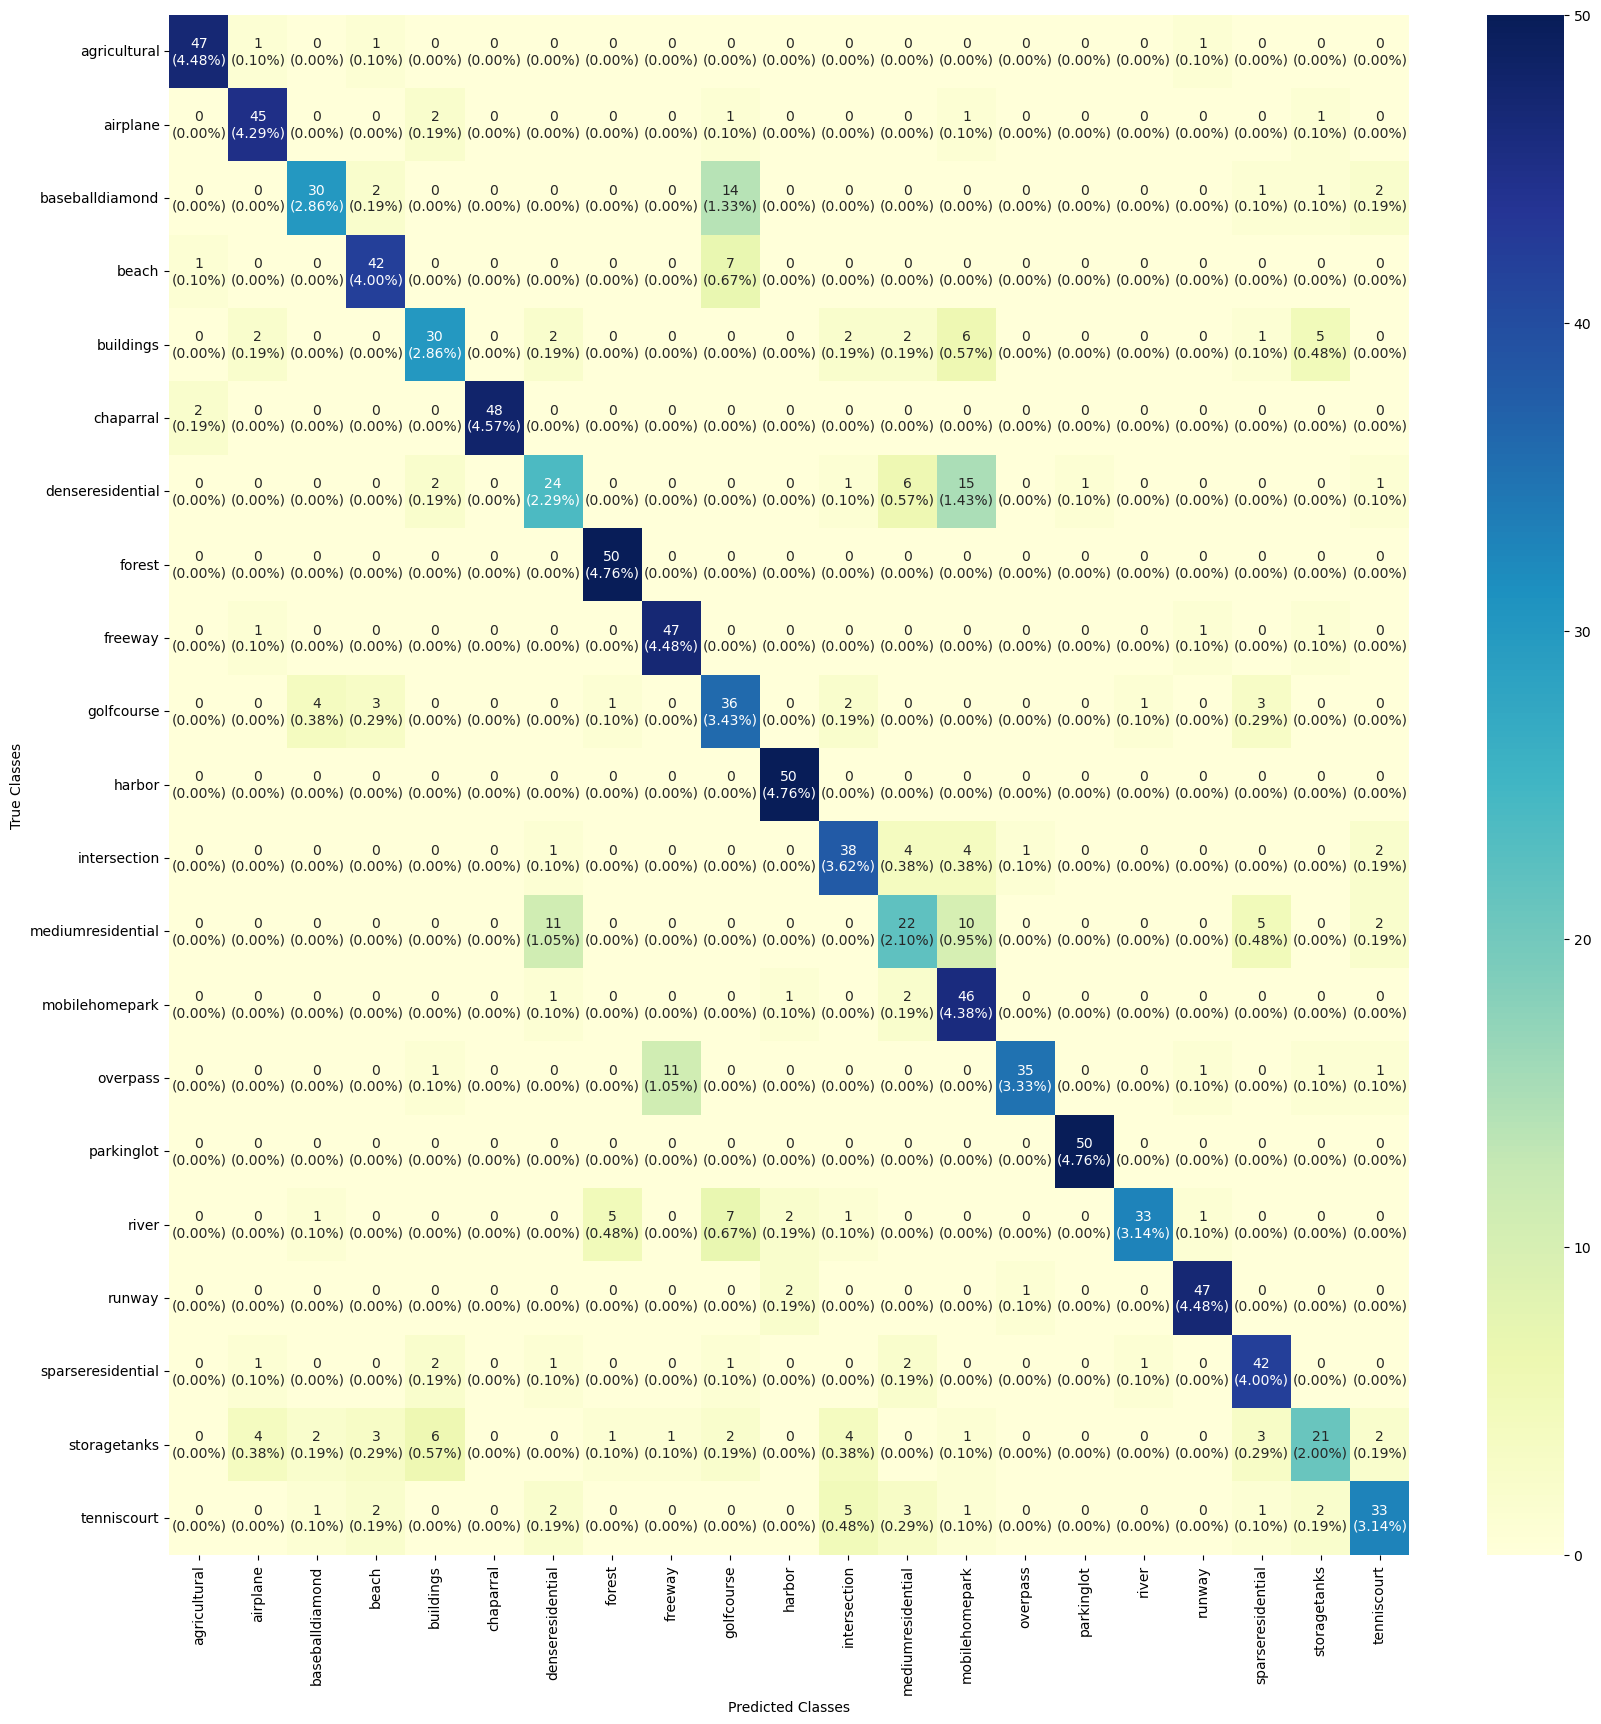

In [67]:
cf_mtx1 = confusion_matrix(y_true1, y_pred1)

group_counts = ["{0:0.0f}".format(value) for value in cf_mtx1.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_mtx1.flatten() / np.sum(cf_mtx)]
box_labels = [f"{v1}\n({v2})" for v1, v2 in zip(group_counts, group_percentages)]
box_labels = np.asarray(box_labels).reshape(cf_mtx.shape)  # Modify this line to use cf_mtx.shape instead of hardcoding (441, 441)

plt.figure(figsize=(20, 20))
sns.heatmap(cf_mtx1, xticklabels=labels.values(), yticklabels=labels.values(),
            cmap="YlGnBu", fmt="", annot=box_labels)
plt.xlabel('Predicted Classes')
plt.ylabel('True Classes')
plt.show()

In [68]:
df_data1=classification_report(y_true1, y_pred1, target_names=labels.values())

In [69]:
from sklearn.metrics import accuracy_score
accuracy_score(y_true1, y_pred1)

0.7771428571428571

In [70]:
matrix1 = confusion_matrix(y_true1, y_pred1)
matrix1.diagonal()/matrix.sum(axis=1)

array([0.94, 0.9 , 0.6 , 0.84, 0.6 , 0.96, 0.48, 1.  , 0.94, 0.72, 1.  ,
       0.76, 0.44, 0.92, 0.7 , 1.  , 0.66, 0.94, 0.84, 0.42, 0.66])

In [71]:
print(df_data1)

                   precision    recall  f1-score   support

     agricultural       0.94      0.94      0.94        50
         airplane       0.83      0.90      0.87        50
  baseballdiamond       0.79      0.60      0.68        50
            beach       0.79      0.84      0.82        50
        buildings       0.70      0.60      0.65        50
        chaparral       1.00      0.96      0.98        50
 denseresidential       0.57      0.48      0.52        50
           forest       0.88      1.00      0.93        50
          freeway       0.80      0.94      0.86        50
       golfcourse       0.53      0.72      0.61        50
           harbor       0.91      1.00      0.95        50
     intersection       0.72      0.76      0.74        50
mediumresidential       0.54      0.44      0.48        50
   mobilehomepark       0.55      0.92      0.69        50
         overpass       0.95      0.70      0.80        50
       parkinglot       0.98      1.00      0.99       

In [72]:
def create_model_with_strides():
    model = Sequential([
        Conv2D(filters=128, kernel_size=(5, 5), strides=(1, 1), padding='same', input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        
        Conv2D(filters=64, kernel_size=(3, 3), strides=(2, 2), padding='same', kernel_regularizer=l2(0.00005)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        
        Conv2D(filters=32, kernel_size=(3, 3), strides=(2, 2), padding='same', kernel_regularizer=l2(0.00005)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        
        Flatten(),
        
        Dense(units=256, activation='relu'),
        Dropout(0.1),
        Dense(units=21, activation='softmax')
    ])
    
    return model

In [73]:
create_model_with_strides = create_model_with_strides()

In [74]:
print(create_model_with_strides.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 256, 256, 128)     9728      
                                                                 
 activation_7 (Activation)   (None, 256, 256, 128)     0         
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 128, 128, 128)     0         
 g2D)                                                            
                                                                 
 batch_normalization_7 (Bat  (None, 128, 128, 128)     512       
 chNormalization)                                                
                                                                 
 conv2d_8 (Conv2D)           (None, 64, 64, 64)        73792     
                                                                 
 activation_8 (Activation)   (None, 64, 64, 64)       

In [75]:
create_model_with_strides.compile(optimizer=optimizer, loss=CategoricalCrossentropy(), metrics=['accuracy'])

In [76]:
history_with_strides = create_model_with_strides.fit(train_generator, epochs=50, validation_data=validation_generator,
                       verbose=2,
                       callbacks=[reduce_lr])

Epoch 1/50
230/230 - 250s - loss: 2.6098 - accuracy: 0.2352 - val_loss: 4.2885 - val_accuracy: 0.0505 - lr: 3.1623e-05 - 250s/epoch - 1s/step
Epoch 2/50
230/230 - 248s - loss: 2.1364 - accuracy: 0.3502 - val_loss: 3.4368 - val_accuracy: 0.1286 - lr: 3.1623e-05 - 248s/epoch - 1s/step
Epoch 3/50
230/230 - 249s - loss: 1.9839 - accuracy: 0.3863 - val_loss: 1.9179 - val_accuracy: 0.4076 - lr: 3.1623e-05 - 249s/epoch - 1s/step
Epoch 4/50
230/230 - 247s - loss: 1.8637 - accuracy: 0.4181 - val_loss: 1.8017 - val_accuracy: 0.4271 - lr: 3.1623e-05 - 247s/epoch - 1s/step
Epoch 5/50
230/230 - 249s - loss: 1.7872 - accuracy: 0.4505 - val_loss: 1.6805 - val_accuracy: 0.4595 - lr: 3.1623e-05 - 249s/epoch - 1s/step
Epoch 6/50
230/230 - 249s - loss: 1.7002 - accuracy: 0.4690 - val_loss: 1.6358 - val_accuracy: 0.4867 - lr: 3.1623e-05 - 249s/epoch - 1s/step
Epoch 7/50
230/230 - 249s - loss: 1.6487 - accuracy: 0.4856 - val_loss: 1.6640 - val_accuracy: 0.4705 - lr: 3.1623e-05 - 249s/epoch - 1s/step
Epoch 

In [77]:
train_accuracy_with_strides = history_with_strides.history['accuracy']
                                 
val_accuracy_with_strides = history_with_strides.history['val_accuracy']

train_loss_with_strides = history_with_strides.history['loss']
val_loss_with_strides = history_with_strides.history['val_loss']

learning_rate_with_strides = history_with_strides.history['lr']

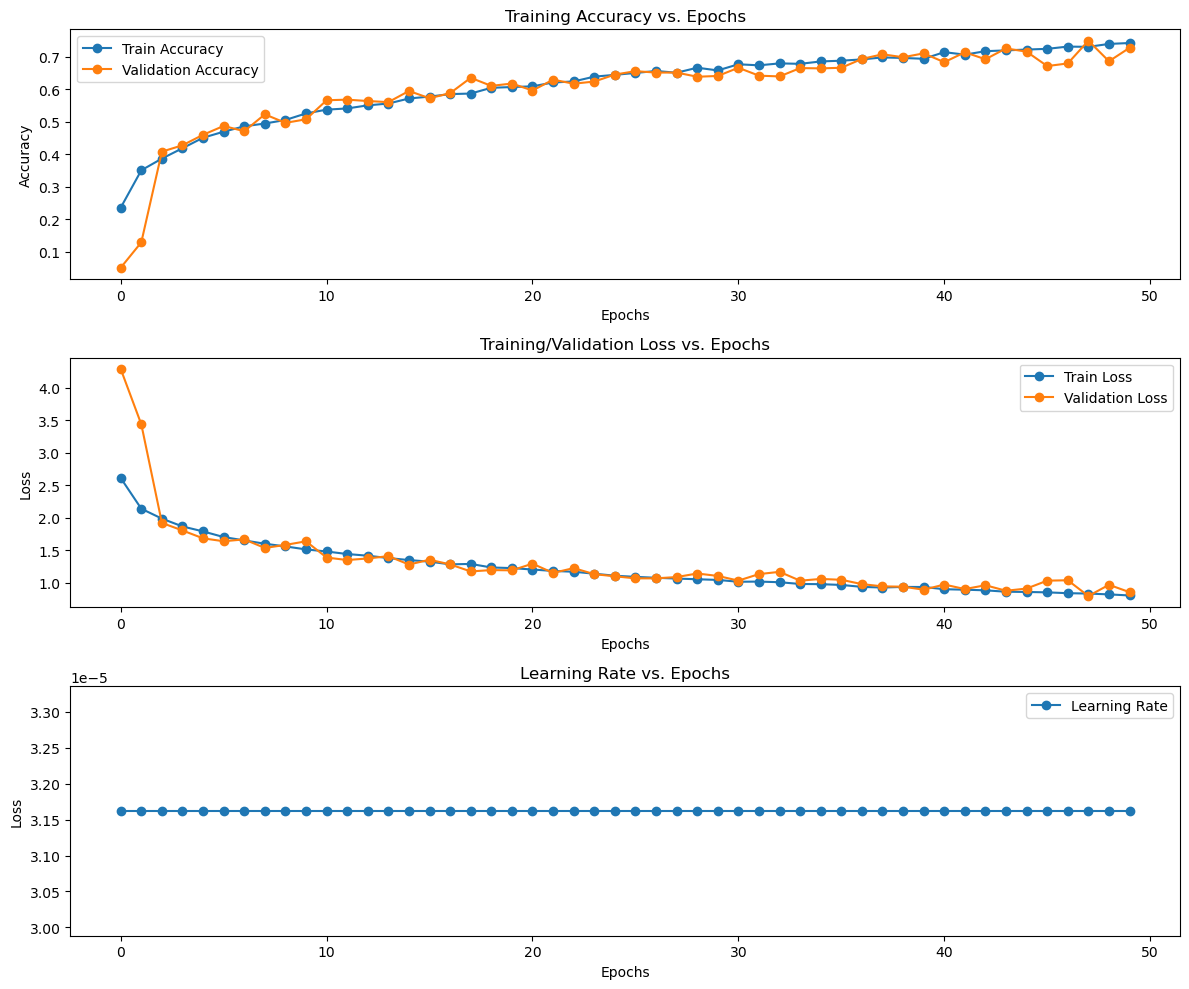

In [78]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(12, 10))

ax[0].set_title('Training Accuracy vs. Epochs')
ax[0].plot(train_accuracy_with_strides, 'o-', label='Train Accuracy')
ax[0].plot(val_accuracy_with_strides, 'o-', label='Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='best')

ax[1].set_title('Training/Validation Loss vs. Epochs')
ax[1].plot(train_loss_with_strides, 'o-', label='Train Loss')
ax[1].plot(val_loss_with_strides, 'o-', label='Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='best')

ax[2].set_title('Learning Rate vs. Epochs')
ax[2].plot(learning_rate_with_strides, 'o-', label='Learning Rate')
ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('Loss')
ax[2].legend(loc='best')

plt.tight_layout()
plt.show()

In [79]:
test_loss_with_strides, test_accuracy_with_strides = cnn_model.evaluate(test_generator, batch_size=BATCH_SIZE)

33/33 [==============================] - 11s 341ms/step - loss: 0.7586 - accuracy: 0.7771


In [80]:
print(f"Test Loss:     {test_loss_with_strides}")
print(f"Test Accuracy: {test_accuracy_with_strides}")

Test Loss:     0.7586423754692078
Test Accuracy: 0.7771428823471069


In [81]:
y_pred_with_strides = np.argmax(predictions, axis=1)
y_true_with_strides = test_generator.classes

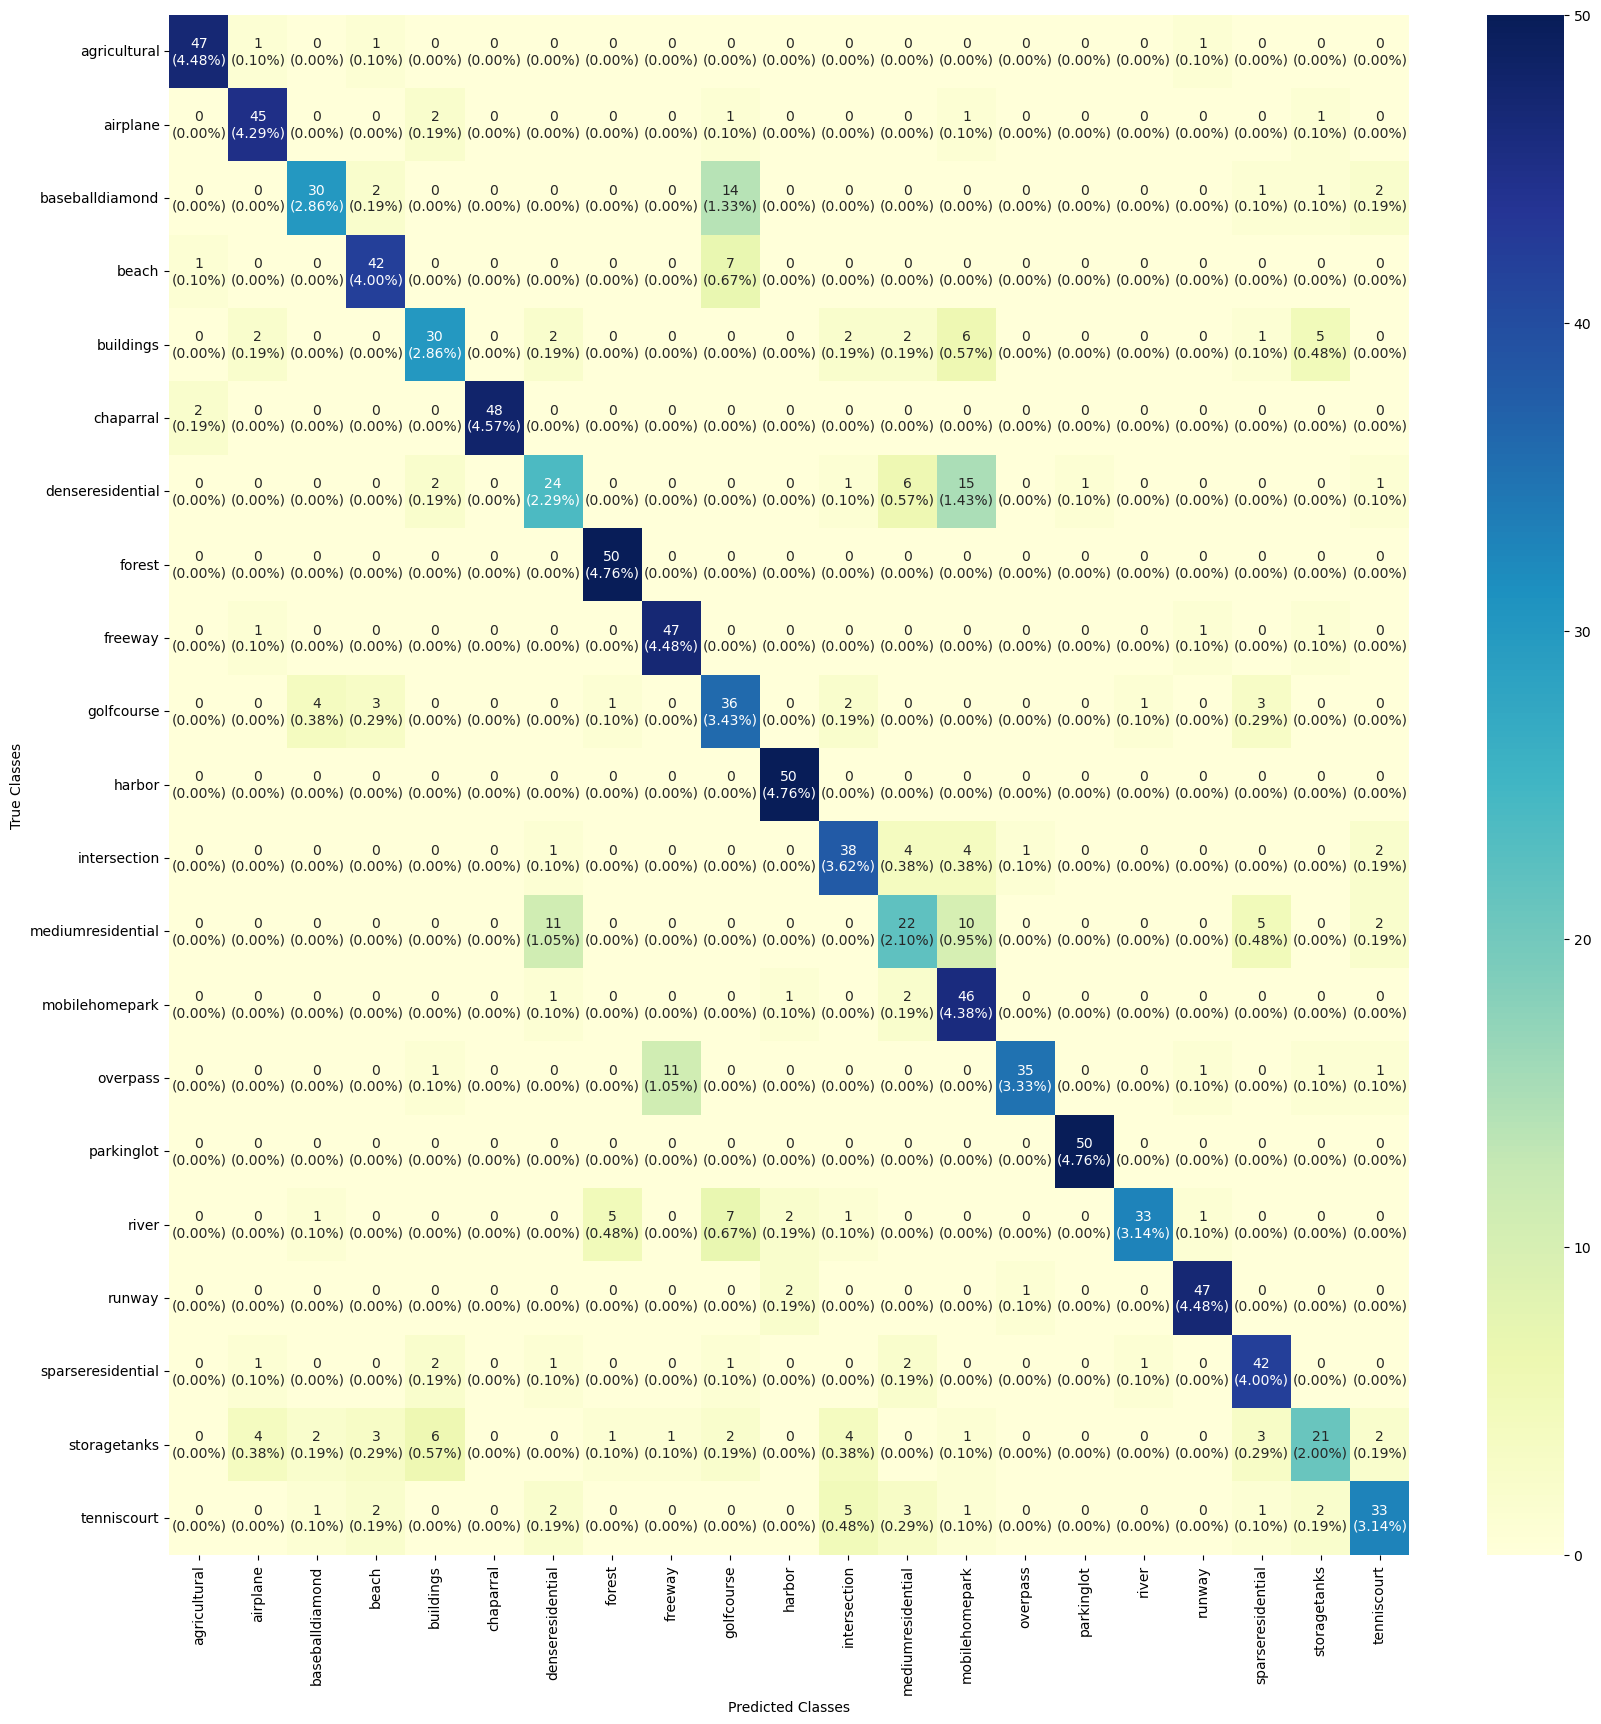

In [82]:
cf_mtx_with_strides = confusion_matrix(y_true, y_pred)

group_counts = ["{0:0.0f}".format(value) for value in cf_mtx.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_mtx_with_strides.flatten() / np.sum(cf_mtx)]
box_labels = [f"{v1}\n({v2})" for v1, v2 in zip(group_counts, group_percentages)]
box_labels = np.asarray(box_labels).reshape(cf_mtx.shape)  # Modify this line to use cf_mtx.shape instead of hardcoding (441, 441)

plt.figure(figsize=(20, 20))
sns.heatmap(cf_mtx_with_strides, xticklabels=labels.values(), yticklabels=labels.values(),
            cmap="YlGnBu", fmt="", annot=box_labels)
plt.xlabel('Predicted Classes')
plt.ylabel('True Classes')
plt.show()

In [83]:
df_data_with_strides=classification_report(y_true_with_strides, y_pred_with_strides, target_names=labels.values())

In [84]:
from sklearn.metrics import accuracy_score
accuracy_score(y_true_with_strides, y_pred_with_strides)

0.7771428571428571

In [85]:
print(df_data_with_strides)

                   precision    recall  f1-score   support

     agricultural       0.94      0.94      0.94        50
         airplane       0.83      0.90      0.87        50
  baseballdiamond       0.79      0.60      0.68        50
            beach       0.79      0.84      0.82        50
        buildings       0.70      0.60      0.65        50
        chaparral       1.00      0.96      0.98        50
 denseresidential       0.57      0.48      0.52        50
           forest       0.88      1.00      0.93        50
          freeway       0.80      0.94      0.86        50
       golfcourse       0.53      0.72      0.61        50
           harbor       0.91      1.00      0.95        50
     intersection       0.72      0.76      0.74        50
mediumresidential       0.54      0.44      0.48        50
   mobilehomepark       0.55      0.92      0.69        50
         overpass       0.95      0.70      0.80        50
       parkinglot       0.98      1.00      0.99       

In [86]:
print(f"{df_data},{df_data1},{df_data_with_strides}")

                   precision    recall  f1-score   support

     agricultural       0.94      0.94      0.94        50
         airplane       0.83      0.90      0.87        50
  baseballdiamond       0.79      0.60      0.68        50
            beach       0.79      0.84      0.82        50
        buildings       0.70      0.60      0.65        50
        chaparral       1.00      0.96      0.98        50
 denseresidential       0.57      0.48      0.52        50
           forest       0.88      1.00      0.93        50
          freeway       0.80      0.94      0.86        50
       golfcourse       0.53      0.72      0.61        50
           harbor       0.91      1.00      0.95        50
     intersection       0.72      0.76      0.74        50
mediumresidential       0.54      0.44      0.48        50
   mobilehomepark       0.55      0.92      0.69        50
         overpass       0.95      0.70      0.80        50
       parkinglot       0.98      1.00      0.99       